# Bifurcation process synthetic data generation


### Important !!!

The execution of this notebook relies on the tree structure being the same as in [Subdirectory M2](https://github.com/bnediction/gustavo/tree/M2/M2)

In [49]:
# type hints
from typing import Iterator, Dict
RandomWalkGenerator = Iterator[Dict[str,int]]

# visualisation
import matplotlib.pyplot as plt
import plotnine as gg
import random
from networkx.drawing.nx_agraph import graphviz_layout

# data io
import numpy as np
import pandas as pd

# generation of unique identifiers for reproducibility
from IPython import get_ipython
ipython = get_ipython()
import datetime as dt

from scboolseq import scBoolSeq
from scboolseq.simulation import (
    biased_simulation_from_binary_state,
    _simulate_subset,
    simulate_gene, 
    simulate_bimodal_gene,
    simulate_unimodal_gene
)
from scboolseq.utils.customobjs import (
    Path, 
    ObjDict as odict
)
from scboolseq.utils.stream_helpers import *

# Boolean networks
import ginsim
import networkx as nx
from colomoto.minibn import *

# miscellaneous
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy.spatial.distance import jaccard, squareform, pdist
from sklearn.metrics.pairwise import pairwise_distances
import pickle
from itertools import chain, combinations, product # For powerset calculation
from functools import partial # in order to pre-load functions before passing them to
                              # a pd.DataFrame.index.map()
from scipy.spatial.distance import jaccard as jaccard_distance # To compute the similarity between critical nodes
lmap = lambda f, x: list(map(f, x))
now = lambda: str(dt.datetime.now()).split('.')[0].replace(" ", "_").replace(":", "h", 1).replace(":", "m")

# set the project root and create diferent locations
root = Path(".").resolve()
locations = odict({
    "root": root,
    "data": root.joinpath("../data/").resolve(),
    "criteriae": root.joinpath("../criteriae").resolve(),
    "synthetic_data": root.joinpath("../synthetic_data/").resolve()
})

# set seed for reproducible results
_rng_seed = 19834650
# use a Generator instead of numpy's singleton
_rng = np.random.default_rng(_rng_seed)

# Visualise the paths
for name, location in locations.items():
    if not location.exists():
        raise FileNotFoundError(f"Specified location \n{location}\n does not exist !")
    #print(f"{name} -> {location}")

### Load criteriae learnt on the Nestorowa Hematopoiesis Dataset (after feature selection via STREAM)

In [2]:
criteriae = odict({
    criteria.name.replace("scBoolSeq_Nestorowa_", "").replace(".csv", ""): pd.read_csv(criteria, index_col=0)
    for criteria in locations.criteriae.glob("*csv")
})
criteriae.lkeys

['simulation_criteria']

In [3]:
criteria = criteriae.simulation_criteria
print(f"* Categories on simulation criteria:\n{criteria.Category.value_counts()}\n")
criteria.head()

* Categories on simulation criteria:
Bimodal      2922
Unimodal     1645
Discarded     201
Name: Category, dtype: int64



,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category
Clec1b,0.994849,1.635698,6.166711,0.876208,1.520978,-0.007249,8.852181,0.986140,0.013860,0.111291,5.666490,0.157649,1.520978,2.666760,0.25,0.667271,1.555290,0.888020,0.968776,2.785740,3.094168,Unimodal
Mns1,0.000000,2.066577,-1.366120,0.100242,4.743786,1.884848,10.862714,0.607455,0.392545,1.949125,7.857075,1.948831,4.743786,9.166517,0.25,1.994418,7.569707,5.575288,3.798141,4.043072,6.026639,Bimodal
Zfp758,0.000000,2.656696,-1.077530,0.410024,3.392367,0.032378,10.114596,0.802972,0.197028,0.716757,7.236947,0.952938,3.392367,8.305333,0.25,1.103814,6.430069,5.326255,1.911847,3.691636,4.635897,Bimodal
Zfp655,0.000000,2.375439,-1.429402,0.179348,4.114937,0.887514,10.453106,0.653967,0.346033,1.296866,7.308042,1.449121,4.114937,8.699362,0.25,1.419807,7.125837,5.706030,2.970440,3.740356,5.248518,Bimodal
Srxn1,0.001124,2.538884,-0.893849,0.690217,3.146476,0.006911,10.074096,0.895532,0.104468,0.303613,6.727692,0.598964,3.146476,7.578089,0.25,0.962015,5.719712,4.757697,1.682418,3.431388,4.041717,Bimodal


## Set experiment name

In [4]:
_prefix = "core_regulation1"
experiment_name = f"{_prefix}_{now()}"
experiment_name

'core_regulation1_2022-04-28_09h34m07'

## Load the model

Either declare it or use one of the preloaded models.

In [6]:
from models import CORE_REGULATION_1 as core_reg
config_bn = bn_config = core_reg.network
bn = BooleanNetwork(bn_config)
bn

G1 <- TF1
G2 <- TF1
G3 <- TF1
G4 <- TF2
G5 <- TF2
G6 <- TF2
TF1 <- TF3&!TF2
TF2 <- TF3&!TF1
TF3 <- TF4
TF4 <- TF5
TF5 <- TF6
TF6 <- 1

# computing graph layout...


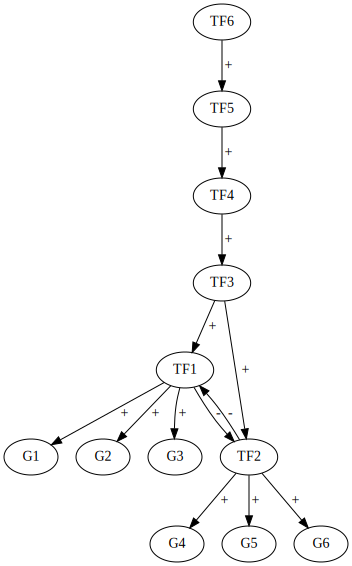

In [7]:
bn.influence_graph()

In [8]:
dynamics = FullyAsynchronousDynamics(bn)

Manually declare all the states of interest

In [9]:
state_full_zero = bn.zero()
# Start copying the full-zero state
states = odict({
    state: state_full_zero.copy()
    for state in "init|branching|fixed_point_1|fixed_point_2".split("|")
})

# Declare genes which are set to one 
_states_ones = odict({
    "init": "TF6".split("|"),
    "branching": "TF6|TF5|TF4|TF3".split("|"),
    "fixed_point_1": "TF6|TF5|TF4|TF3|TF1|G1|G2|G3".split("|"),
    "fixed_point_2": "TF6|TF5|TF4|TF3|TF2|G4|G4|G6".split("|"),
})

# Iterate over 'states' dict to update the values
# performing integrity checks on each step
for _state_key in states.keys():
    if all(i in bn_config for i in _states_ones[_state_key]):
        states[_state_key].update({gene: 1 for gene in _states_ones[_state_key]})
    else:
        raise ValueError(
            "\n".join([
                f"When updating state `{_state_key}`, "
                f"at least one of {_states_ones[_state_key]} not found in the boolean network variables."
                "This is probably due to a typo, check they are all correctly spelled"
            ])
        )

## Graph-based manual construction of trajectories of interest

Compute transition graph from the initial state and show its cadinality.

Compute a subset ot the accessible transition graph from the initial state, considering the graph induced by taking the succesors of the branching point.
This may reduce the computation time of inferring the shortest trajectories from the initial state to each
one of the fixed point attractors

In [10]:
transition_graph = dynamics.partial_dynamics(states["init"])
print(f"stg has {len(transition_graph)} nodes")

stg has 20 nodes


In [11]:
condensation = nx.condensation(transition_graph)
print(f"condensation has {len(condensation)} nodes")

condensation has 20 nodes


# computing graph layout...


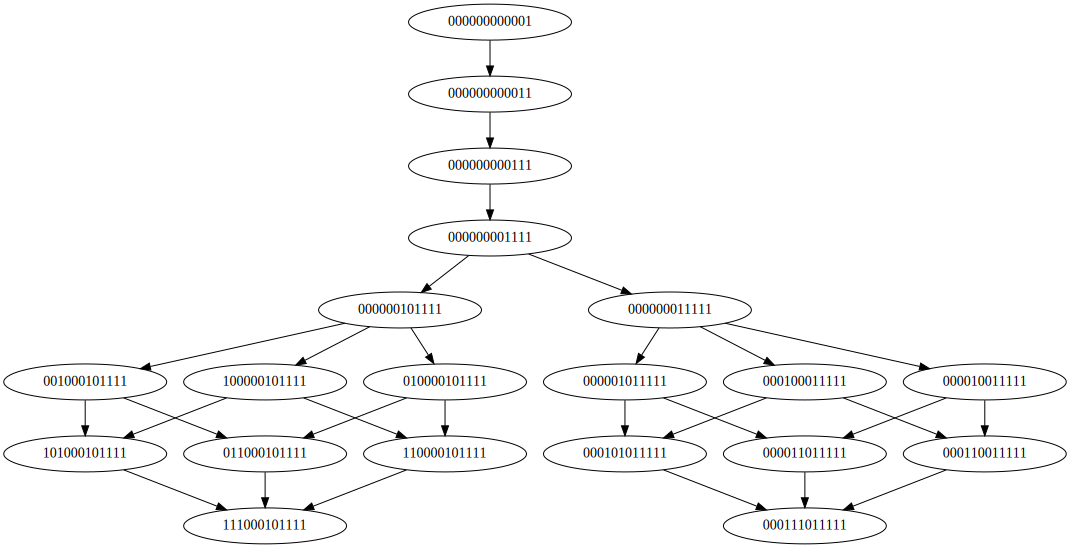

In [12]:
transition_graph

In [13]:
shortest_path_passing_by(
    transition_graph,
    states["init"],
    states["branching"],
    states["fixed_point_1"]
)

['000000000001',
 '000000000011',
 '000000000111',
 '000000001111',
 '000000101111',
 '001000101111',
 '011000101111',
 '111000101111']

## Study the attractors

In [14]:
_to_state = partial(graph_node_to_dict, dynamics)

_traj1 = map(_to_state,
    shortest_path_passing_by(
        transition_graph,
        states["init"],
        states["branching"],
        states["fixed_point_1"]
    )
)

_traj2 = map(_to_state,
    shortest_path_passing_by(
        transition_graph,
        states["init"],
        states["branching"],
        states["fixed_point_2"]
    )
)

_traj1_df = trajectory_to_data_frame(_traj1)
_traj2_df = trajectory_to_data_frame(_traj2)
_traj2_df

,G1,G2,G3,G4,G5,G6,TF1,TF2,TF3,TF4,TF5,TF6
step,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,1,1,1
3,0,0,0,0,0,0,0,0,1,1,1,1
4,0,0,0,0,0,0,0,1,1,1,1,1
5,0,0,0,1,0,0,0,1,1,1,1,1
6,0,0,0,1,0,1,0,1,1,1,1,1


# computing graph layout...


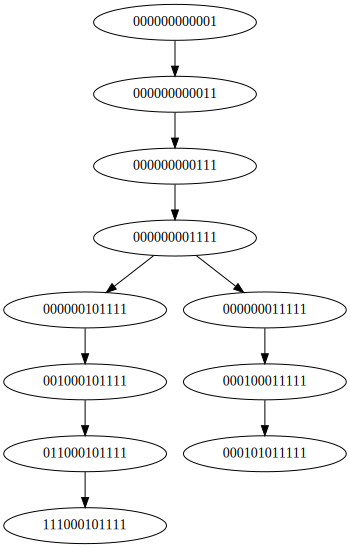

In [38]:
c1 = ["".join(map(str, d.values)) for _,d in _traj1_df.iterrows()]
c2 = ["".join(map(str, d.values)) for _,d in _traj2_df.iterrows()]
branching_binary_trajectory = nx.DiGraph(list(zip(c1[:-1],c1[1:]))+list(zip(c2[:-1], c2[1:])))
branching_binary_trajectory

In [39]:
len(nx.DiGraph(list(zip(c1[:-1],c1[1:]))+list(zip(c2[:-1], c2[1:]))))

11

In [40]:
random_walk_df = merged_trajectories_df = merge_binary_trajectories(
    trajectories=[_traj1_df, _traj2_df],
    labels = ["fixed_point_1", "fixed_point_2"],
    branching_point_query=boolean_df_query_generator(states["branching"]),
    attractor_queries=[
        boolean_df_query_generator(states["fixed_point_1"]),
        boolean_df_query_generator(states["fixed_point_2"])
    ],
    confound_observations=True
).drop_duplicates()
merged_trajectories_df

,G1,G2,G3,G4,G5,G6,TF1,TF2,TF3,TF4,TF5,TF6
label,,,,,,,,,,,,
common,0,0,0,0,0,0,0,0,0,0,0,1
common,0,0,0,0,0,0,0,0,0,0,1,1
common,0,0,0,0,0,0,0,0,0,1,1,1
split,0,0,0,0,0,0,0,0,1,1,1,1
branch_fixed_point_1,0,0,0,0,0,0,1,0,1,1,1,1
branch_fixed_point_1,0,0,1,0,0,0,1,0,1,1,1,1
branch_fixed_point_1,0,1,1,0,0,0,1,0,1,1,1,1
attractor_fixed_point_1,1,1,1,0,0,0,1,0,1,1,1,1
branch_fixed_point_2,0,0,0,0,0,0,0,1,1,1,1,1


In [41]:
merged_trajectories_df.reset_index().label.value_counts() / merged_trajectories_df.shape[0]

common                     0.272727
branch_fixed_point_1       0.272727
branch_fixed_point_2       0.181818
split                      0.090909
attractor_fixed_point_1    0.090909
attractor_fixed_point_2    0.090909
Name: label, dtype: float64

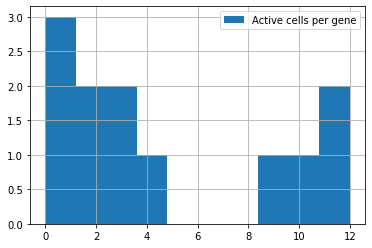

In [42]:
(merged_trajectories_df.mean() * merged_trajectories_df.shape[1] ).hist(**{"label": "Active cells per gene"})
plt.legend()

In [43]:
categories = merged_trajectories_df.reset_index().groupby("label").mean().index.to_list()
mean_exp_by_label = merged_trajectories_df.reset_index().groupby("label").mean() 
mean_exp_by_label

,G1,G2,G3,G4,G5,G6,TF1,TF2,TF3,TF4,TF5,TF6
label,,,,,,,,,,,,
attractor_fixed_point_1,1.0,1.000000,1.000000,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.000000,1.0
attractor_fixed_point_2,0.0,0.000000,0.000000,1.0,0.0,1.0,0.0,1.0,1.0,1.000000,1.000000,1.0
branch_fixed_point_1,0.0,0.333333,0.666667,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.000000,1.0
branch_fixed_point_2,0.0,0.000000,0.000000,0.5,0.0,0.0,0.0,1.0,1.0,1.000000,1.000000,1.0
common,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.666667,1.0
split,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,1.0


In [22]:
mean_bool_exp_by_label = mean_exp_by_label > 0.5
mean_bool_exp_by_label

,G1,G2,G3,G4,G5,G6,TF1,TF2,TF3,TF4,TF5,TF6
label,,,,,,,,,,,,
attractor_fixed_point_1,True,True,True,False,False,False,True,False,True,True,True,True
attractor_fixed_point_2,False,False,False,True,False,True,False,True,True,True,True,True
branch_fixed_point_1,False,False,True,False,False,False,True,False,True,True,True,True
branch_fixed_point_2,False,False,False,False,False,False,False,True,True,True,True,True
common,False,False,False,False,False,False,False,False,False,False,True,True
split,False,False,False,False,False,False,False,False,True,True,True,True


In [23]:
jac_sim = pd.DataFrame(
    1 - pairwise_distances(mean_bool_exp_by_label, metric = "hamming"), 
    index=mean_bool_exp_by_label.T.columns, 
    columns=mean_bool_exp_by_label.T.columns
)
jac_sim

label,attractor_fixed_point_1,attractor_fixed_point_2,branch_fixed_point_1,branch_fixed_point_2,common,split
label,,,,,,
attractor_fixed_point_1,1.000000,0.416667,0.833333,0.583333,0.500000,0.666667
attractor_fixed_point_2,0.416667,1.000000,0.583333,0.833333,0.583333,0.750000
branch_fixed_point_1,0.833333,0.583333,1.000000,0.750000,0.666667,0.833333
branch_fixed_point_2,0.583333,0.833333,0.750000,1.000000,0.750000,0.916667
common,0.500000,0.583333,0.666667,0.750000,1.000000,0.833333
split,0.666667,0.750000,0.833333,0.916667,0.833333,1.000000


In [24]:
jac_sim.mean().describe()

count    6.000000
mean     0.750000
std      0.065734
min      0.666667
25%      0.701389
50%      0.750000
75%      0.798611
max      0.833333
dtype: float64

In [25]:
dist_pdist = squareform(pairwise_distances(mean_bool_exp_by_label, metric = "hamming"), force='tovector')
dist_pdist

array([0.58333333, 0.16666667, 0.41666667, 0.5       , 0.33333333,
       0.41666667, 0.16666667, 0.41666667, 0.25      , 0.25      ,
       0.33333333, 0.16666667, 0.25      , 0.08333333, 0.16666667])

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [25.0, 25.0, 42.5, 42.5],
  [10.0, 10.0, 33.75, 33.75]],
 'dcoord': [[0.0, 0.16666666666666666, 0.16666666666666666, 0.0],
  [0.0, 0.08333333333333333, 0.08333333333333333, 0.0],
  [0.0, 0.20833333333333331, 0.20833333333333331, 0.08333333333333333],
  [0.0, 0.27777777777777773, 0.27777777777777773, 0.20833333333333331],
  [0.16666666666666666, 0.375, 0.375, 0.27777777777777773]],
 'ivl': ['0', '2', '4', '1', '3', '5'],
 'leaves': [0, 2, 4, 1, 3, 5],
 'color_list': ['C1', 'C2', 'C2', 'C0', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C0', 'C2', 'C2', 'C2']}

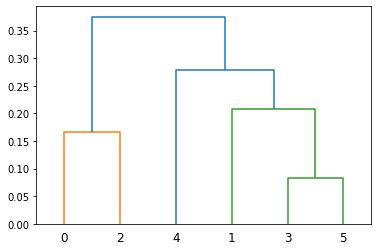

In [26]:
dendrogram(linkage(dist_pdist, method="average"))

In [29]:
# perform random sampling over bimodal genes
random_criteria = criteria[
    (criteria.Category == "Bimodal") &
    (criteria.DropOutRate < 0.05)
].sample(len(random_walk_df.columns), random_state=_rng_seed)
dummy_criteria = random_criteria.copy(deep=True).set_index(random_walk_df.columns)
dummy_criteria

,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category
G1,0.000000,2.204589,-1.296402,0.030193,5.937746,8.215683,10.802706,0.384682,0.615318,2.330445,7.901582,1.511589,5.937746,8.074533,0.25,3.048493,8.326143,5.277650,7.024974,4.190001,5.790008,Bimodal
G2,0.000000,2.140588,-1.304451,0.022343,5.832109,8.004510,10.580911,0.383947,0.616053,2.428006,7.742154,1.457776,5.832109,7.568155,0.25,3.100140,8.126594,5.026454,6.759009,4.149689,5.782134,Bimodal
G3,0.004504,1.965144,-0.980230,0.015097,6.642170,8.678775,10.986034,0.330903,0.669097,2.941889,8.322288,1.659703,6.642170,7.531391,0.25,4.199070,8.845707,4.646637,7.635968,4.485248,6.325673,Bimodal
G4,0.000000,2.176400,-1.374235,0.025966,5.554317,7.572444,10.661850,0.411331,0.588669,2.249071,7.618852,1.474003,5.554317,7.885181,0.25,2.675313,7.843694,5.168381,6.493051,4.005325,5.647730,Bimodal
G5,0.000061,1.879387,-0.486789,0.006643,7.058469,8.157439,11.756951,0.257121,0.742879,3.011898,8.395932,1.567614,7.058469,6.825287,0.25,5.324472,8.902677,3.578205,7.790254,4.527685,6.256280,Bimodal
G6,0.000000,2.006684,-1.438835,0.039251,4.940110,1.981498,10.756183,0.521854,0.478146,2.281369,7.436358,1.646672,4.940110,7.662534,0.25,2.236204,7.548938,5.312735,4.847397,3.942588,5.833530,Bimodal
TF1,0.008914,1.829326,0.071704,0.004831,7.328485,8.409098,11.552874,0.203062,0.796938,3.112956,8.358191,1.330458,7.328485,5.554741,0.25,6.514508,8.940043,2.425536,8.038056,4.616778,6.158220,Bimodal
TF2,0.000000,2.317892,-0.841413,0.006643,6.735458,8.508093,12.133093,0.294334,0.705666,2.790051,8.317693,1.181227,6.735458,7.280929,0.25,4.148332,8.752579,4.604247,7.884896,4.731106,5.999278,Bimodal
TF3,0.000000,2.031749,-1.390363,0.017512,5.737975,2.909405,12.007258,0.568352,0.431648,3.161875,8.897138,1.954851,5.737975,9.632509,0.25,2.941206,8.722994,5.781788,4.991103,5.107170,7.137512,Bimodal
TF4,0.000000,2.574075,-1.477778,0.032005,5.897388,8.547923,11.345699,0.413554,0.586446,2.054376,8.285580,1.421221,5.897388,10.089566,0.25,2.459253,8.667932,6.208679,7.271125,4.409922,5.786097,Bimodal


In [30]:
dummy_criteria.DropOutRate.describe()

count    12.000000
mean      0.019475
std       0.010949
min       0.004831
25%       0.011624
50%       0.018720
75%       0.027023
max       0.039251
Name: DropOutRate, dtype: float64

In [44]:
# `simulate_from_boolean_trajectory()` is defined within scboolseq.utils.stream_helpers
# the main class has also an alias: `scBoolSeq(simulation_criteria=df).simulate_with_metadata()`
synthetic_single_cell_experiment, metadata = simulate_from_boolean_trajectory(
    boolean_trajectory_df=random_walk_df,
    criteria_df=dummy_criteria,
    n_samples_per_state=400,
    rng_seed=1928327465
)

In [45]:
synthetic_single_cell_experiment.head()

,G1,G2,G3,G4,G5,G6,TF1,TF2,TF3,TF4,TF5,TF6
common_obs0,3.743501,2.588296,1.732137,2.863299,1.717044,3.052297,2.293612,3.598360,2.069357,3.805104,2.980470,7.645622
common_obs1,1.103293,0.403474,0.000000,1.543100,3.384701,3.529317,4.681488,3.719050,0.947744,0.450221,2.756320,6.480456
common_obs2,2.909027,4.188847,2.840807,1.357670,2.994909,3.064297,0.355559,1.657030,2.170763,0.600050,1.544560,8.353987
common_obs3,0.691341,3.497351,3.861843,2.547985,3.382821,2.694003,1.692507,3.467172,3.456784,1.943013,1.823256,8.407283
common_obs4,1.791371,0.000000,2.685984,3.930876,2.408275,0.993813,2.411266,3.489611,4.087407,1.185325,2.636291,7.490425


In [46]:
synthetic_single_cell_experiment.tail()

,G1,G2,G3,G4,G5,G6,TF1,TF2,TF3,TF4,TF5,TF6
attractor_fixed_point_2_obs4395,4.500216,3.493887,5.090107,6.596074,6.386249,8.275813,2.553435,8.129867,8.839705,8.065593,8.540596,9.532040
attractor_fixed_point_2_obs4396,2.458129,2.894186,4.148886,6.737456,3.312403,7.955922,0.177818,8.500562,6.748203,9.052862,7.504424,8.291725
attractor_fixed_point_2_obs4397,3.060792,2.485498,4.421259,10.789021,3.340436,8.171429,2.787444,7.469116,10.445885,7.007989,8.709600,7.060903
attractor_fixed_point_2_obs4398,2.346825,2.380665,1.977227,7.629536,2.126156,7.686576,0.479075,9.055738,9.474964,6.251783,6.053620,7.677123
attractor_fixed_point_2_obs4399,2.187345,1.732380,4.544319,4.563060,4.482681,6.514285,2.940570,7.493608,7.338396,8.736149,9.159362,8.883506


In [47]:
metadata.head()

,label,label_color
common_obs0,common,#776547
common_obs1,common,#776547
common_obs2,common,#776547
common_obs3,common,#776547
common_obs4,common,#776547


In [48]:
metadata.tail()

,label,label_color
attractor_fixed_point_2_obs4395,attractor_fixed_point_2,#D3CE1F
attractor_fixed_point_2_obs4396,attractor_fixed_point_2,#D3CE1F
attractor_fixed_point_2_obs4397,attractor_fixed_point_2,#D3CE1F
attractor_fixed_point_2_obs4398,attractor_fixed_point_2,#D3CE1F
attractor_fixed_point_2_obs4399,attractor_fixed_point_2,#D3CE1F


In [50]:
EXPORT = True

if EXPORT:
    print("Exporting data...")
    metadata.to_csv(
        locations.synthetic_data.joinpath(f"metadata_{experiment_name}.tsv"), sep="\t"
    )
    synthetic_single_cell_experiment.T.to_csv(
        locations.synthetic_data.joinpath(f"branching_synthetic_{experiment_name}.tsv"), 
        sep="\t", 
        index=True
    )
    print("Done.")
    
else:
    print("Data was not exported")

Exporting data...
Done.
